<center><h1>1-ab: Introduction to Neural Networks</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


In [1]:
import math
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%run 'utils-data.py'

# Part 1 : Forward and backward passes "by hands"

In [2]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    nx : Taille de l'entrée
    nh : Taille de la sortie de la première couche cachée
    ny : Taille output de la dernière couche
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by

    # Initialize weights with a normal distribution (mean=0, std=0.3)
    params["Wh"] = torch.randn(nh, nx) * 0.3
    params["Wy"] = torch.randn(ny, nh) * 0.3
    
    # Initialize biases as zeros
    params["bh"] = torch.randn(nh)
    params["by"] = torch.randn(ny)

    ####################
    ##      END        #
    ####################
    return params


In [3]:
def forward(params, X):
    """
    params: dictionnary
    X: (n_batch, dimension)
    """
    bsize = X.size(0)
    nh = params["Wh"].size(0)
    ny = params["Wy"].size(0)
    outputs = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for X, htilde, h, ytilde, yhat

    outputs["X"] = X
    outputs["htilde"] = torch.mm(X, params["Wh"].t()) + params["bh"].repeat(bsize, 1)
    outputs["h"] = torch.tanh(outputs["htilde"])
    outputs["ytilde"] = torch.mm(outputs["h"], params["Wy"].t()) + params["by"].repeat(bsize, 1)
    outputs["yhat"] = torch.softmax(outputs["ytilde"], dim=1)

    ####################
    ##      END        #
    ####################

    return outputs["yhat"], outputs


In [4]:
def loss_accuracy(Yhat, Y):

    #####################
    ## Your code here  ##
    #####################

    # Compute the loss 
    L = - torch.mean(torch.sum(Y * torch.log(Yhat)))
    
    # Find the predicted class for each example
    _, indsYhat = torch.max(Yhat, 1)
    _, indsY = torch.max(Y, 1)
    
    # Compute the accuracy (rate of correct predictions)
    acc = 100 * torch.sum(indsYhat == indsY) / indsY.size(0)

    ####################
    ##      END        #
    ####################

    return L, acc


In [5]:
def backward(params, outputs, Y):
    bsize = Y.shape[0]
    grads = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wy, Wh, by, bh

    grads["yhat"] = outputs['yhat'] - Y
    grads["Wy"] = torch.mm(grads["yhat"].t(), outputs["h"]) # / bsize
    grads["by"] = torch.sum(grads["yhat"], dim=0).t() # / bsize
    grads["htilde"] = torch.mm(grads["yhat"], params["Wy"]) * (1 - outputs["h"] ** 2)
    grads["Wh"] = torch.mm(grads["htilde"].t(), outputs["X"]) # / bsize
    grads["bh"] = torch.sum(grads["htilde"]).t() # / bsize

    ####################
    ##      END        #
    ####################
    return grads


In [6]:
def sgd(params, grads, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the params values

    # Update parameters using SGD
    params["Wh"] -= eta * grads["Wh"]
    params["Wy"] -= eta * grads["Wy"]
    params["bh"] -= eta * grads["bh"]
    params["by"] -= eta * grads["by"]
    
    ####################
    ##      END        #
    ####################
    return params


## Global learning procedure "by hands"

/tmp/ipykernel_96864/3223373349.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


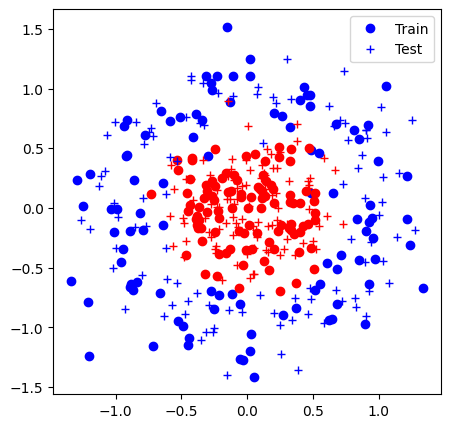

  0%|          | 0/150 [00:00<?, ?it/s]

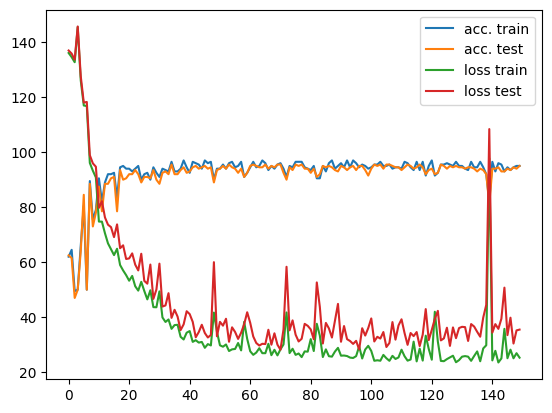

In [7]:
from tqdm.autonotebook import tqdm, trange

# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(150)

# epoch
for iteration in pbar:

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, backward, sgd
        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)

        # Backward pass
        grads = backward(params, outputs, Y)

        # Update parameters using SGD
        params = sgd(params, grads, eta)


    ####################
    ##      END        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    # data.plot_data_with_grid(Ygrid, title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain)
    curves[3].append(Ltest)

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()


# Part 2 : Simplification of the backward pass with `torch.autograd`



In [8]:
def init_params(nx, nh, ny):
    """
    nx, nh, ny: integers
    out params: dictionnary
    """
    params = {}

    #####################
    ## Your code here  ##
    #####################
    # fill values for Wh, Wy, bh, by
    # activaye autograd on the network weights

    # Initialize weights with a normal distribution
    params["Wh"] = torch.randn(nh, nx, requires_grad=True)
    params["Wy"] = torch.randn(ny, nh, requires_grad=True)
    
    # Initialize biases as zeros
    params["bh"] = torch.zeros(nh, requires_grad=True)
    params["by"] = torch.zeros(ny, requires_grad=True)

    ####################
    ##      END        #
    ####################
    return params


The function `forward` remains unchanged from previous part.

The function `backward` is no longer used because of "autograd".

In [9]:
def sgd(params, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():  # Use torch.no_grad() to avoid tracking operations in autograd
        params['Wy'] -= eta * params['Wy'].grad
        params['Wh'] -= eta * params['Wh'].grad
        params['by'] -= eta * params['by'].grad
        params['bh'] -= eta * params['bh'].grad
        
        # Reset the gradient accumulator to zero
        params['Wy'].grad.zero_()
        params['Wh'].grad.zero_()
        params['by'].grad.zero_()
        params['bh'].grad.zero_()
        
    ####################
    ##      END        #
    ####################
    return params


## Global learning procedure with autograd

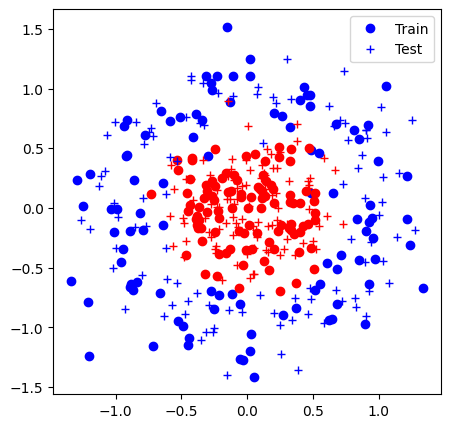

  0%|          | 0/150 [00:00<?, ?it/s]

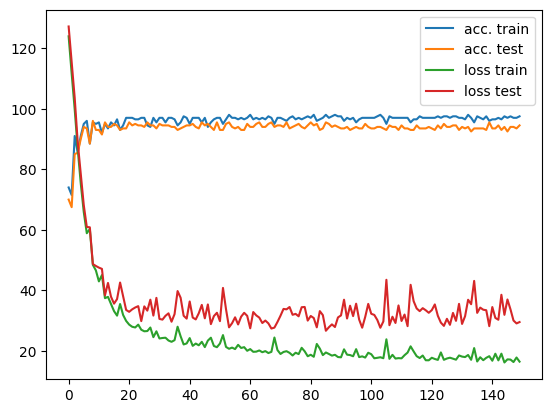

In [10]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

params = init_params(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(150)

# epoch
for iteration in pbar:

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: forward, loss_accuracy, sgd
        # and the backward function with autograd
        # Forward pass
        Yhat, outputs = forward(params, X)

        # Calculate loss and accuracy
        L, acc = loss_accuracy(Yhat, Y)
        L.backward()

        # Update parameters using SGD
        params = sgd(params, eta)


    ####################
    ##      END        #
    ####################

    Yhat_train, _ = forward(params, data.Xtrain)
    Yhat_test, _ = forward(params, data.Xtest)
    Ltrain, acctrain = loss_accuracy(Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(Yhat_test, data.Ytest)
    Ygrid, _ = forward(params, data.Xgrid)


    title = f"Iter {iteration}: Acc train {acctrain:.1f}% ({Ltrain:.2f}), acc test {acctest:.1f}% ({Ltest:.2f})"
    pbar.set_description(title)
    # print(title)
    # detach() is used to remove the predictions from the computational graph in autograd
    # data.plot_data_with_grid(Ygrid.detach(), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach().numpy())
    curves[3].append(Ltest.detach().numpy())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()


# Part 3 : Simplification of the forward pass with `torch.nn`

`init_params` and `forward` are replaced by the `init_model` function which defines the network architecture and the loss.

In [36]:
def init_model(nx, nh, ny):

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh, bias=False),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny, bias=False),
        # torch.nn.Softmax()
    )
    loss = torch.nn.CrossEntropyLoss()

    ####################
    ##      END        #
    ####################

    return model, loss


In [37]:
def loss_accuracy(loss, Yhat, Y):

    #####################
    ## Your code here  ##
    #####################
    # call the loss function
    L = loss(Yhat, Y)

    # Find the predicted class for each example
    _, indsYhat = torch.max(Yhat, 1)
    _, indsY = torch.max(Y, 1)
    
    # Compute the accuracy (rate of correct predictions)
    acc =  torch.sum(indsYhat == indsY) / indsY.size(0)

    ####################
    ##      END        #
    ####################

    return L, acc


In [38]:
def sgd(model, eta):

    #####################
    ## Your code here  ##
    #####################
    # update the network weights
    # warning: use torch.no_grad()
    # and reset to zero the gradient accumulators

    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad
        model.zero_grad()

    ####################
    ##      END        #
    ####################
    return model


## Global learning procedure with autograd and `torch.nn`

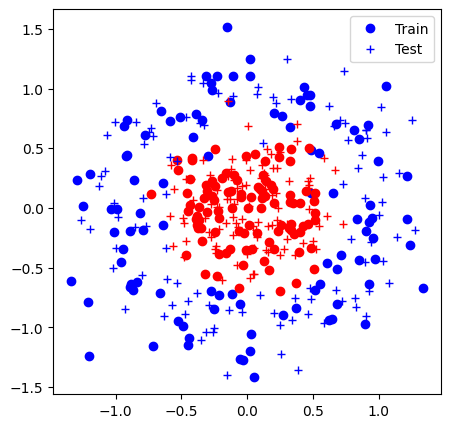

  0%|          | 0/150 [00:00<?, ?it/s]

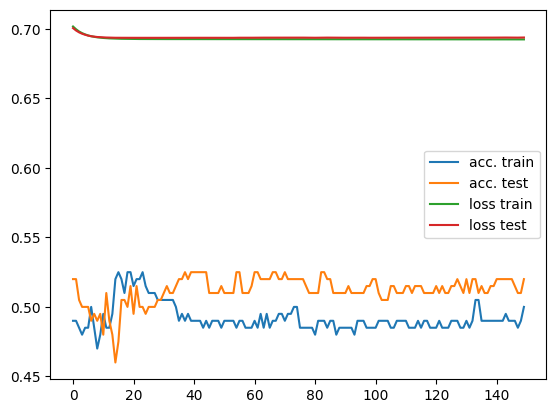

In [39]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss = init_model(nx, nh, ny)

curves = [[], [], [], []]

pbar = trange(150)

# epoch
for iteration in pbar:

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code here  ##
    #####################
    # batches
    for j in range(N // Nbatch):
        model.train()
        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy, sgd
        # the forward with the predict method from the model
        # and the backward function with autograd
        # Forward pass
        Yhat = model(X) 

        # Calculate loss and accuracy
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()

        # Update parameters using SGD
        model = sgd(model, eta)
        
    ####################
    ##      END        #
    ####################
    model.eval()
    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    # data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()


# Part 4 : Simplification of the SGD with `torch.optim`

In [21]:
def init_model(nx, nh, ny, eta):

    #####################
    ## Your code here  ##
    #####################

    model = torch.nn.Sequential(
        torch.nn.Linear(nx, nh),
        torch.nn.Tanh(),
        torch.nn.Linear(nh, ny),
        torch.nn.Softmax()
    )
    loss = torch.nn.CrossEntropyLoss()
    optim = torch.optim.SGD(model.parameters(), lr=eta)

    ####################
    ##      END        #
    ####################

    return model, loss, optim


The `sgd` function is replaced by calling the `optim.zero_grad()` before the backward and `optim.step()` after.

## Algorithme global d'apprentissage (avec autograd, les couches `torch.nn` et `torch.optim`)

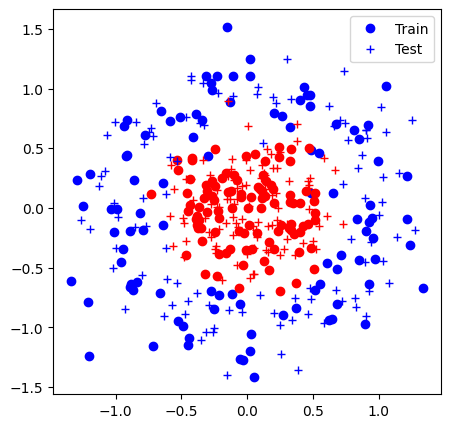

  0%|          | 0/1500 [00:00<?, ?it/s]

/home/aymeric/DAC/.venv/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


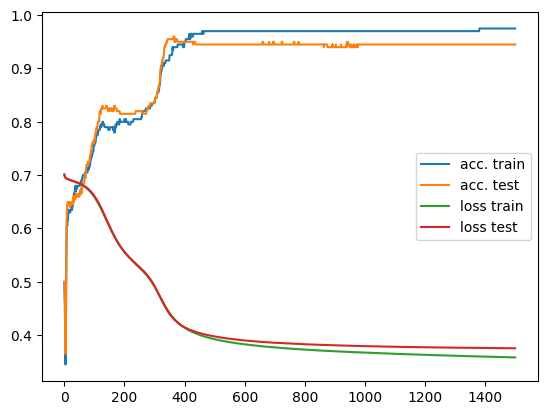

In [22]:
# init
data = CirclesData()
data.plot_data()
N = data.Xtrain.shape[0]
Nbatch = 10
nx = data.Xtrain.shape[1]
nh = 10
ny = data.Ytrain.shape[1]
eta = 0.03

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

pbar = trange(1500)

# epoch
for iteration in pbar:

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an obackwardptimization step
        optim.zero_grad()

        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()
        
        optim.step()


    ####################
    ##      FIN        #
    ####################

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    # data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()


# Part 5 : MNIST

Apply the code from previous part code to the MNIST dataset.

In [35]:
# init
data = MNISTData()
N = data.Xtrain.shape[0]
Nbatch = 100
nx = data.Xtrain.shape[1]
nh = 100
ny = data.Ytrain.shape[1]
eta = 0.03

data.Xtrain.shape

torch.Size([60000, 784])

In [ ]:

model, loss, optim = init_model(nx, nh, ny, eta)

curves = [[], [], [], []]

pbar = trange(1500)

# epoch
for iteration in pbar:

    # permute
    perm = np.random.permutation(N)
    Xtrain = data.Xtrain[perm, :]
    Ytrain = data.Ytrain[perm, :]

    #####################
    ## Your code  here ##
    #####################
    # batches
    for j in range(N // Nbatch):

        indsBatch = range(j * Nbatch, (j + 1) * Nbatch)
        X = Xtrain[indsBatch, :]
        Y = Ytrain[indsBatch, :]

        # write the optimization algorithm on the batch (X,Y)
        # using the functions: loss_accuracy
        # the forward with the predict method from the model
        # the backward function with autograd
        # and then an obackwardptimization step
        optim.zero_grad()

        Yhat = model(X)
        L, acc = loss_accuracy(loss, Yhat, Y)
        L.backward()
        
        optim.step()


    ####################
    ##      FIN        #
    ####################

    Yhat_train = model(data.Xtrain)
    Yhat_test = model(data.Xtest)
    Ltrain, acctrain = loss_accuracy(loss, Yhat_train, data.Ytrain)
    Ltest, acctest = loss_accuracy(loss, Yhat_test, data.Ytest)
    # Ygrid = model(data.Xgrid)

    title = "Iter {}: Acc train {:.1f}% ({:.2f}), acc test {:.1f}% ({:.2f})".format(
        iteration, acctrain, Ltrain, acctest, Ltest
    )
    pbar.set_description(title)
    # print(title)
    # data.plot_data_with_grid(torch.nn.Softmax(dim=1)(Ygrid.detach()), title)

    curves[0].append(acctrain)
    curves[1].append(acctest)
    curves[2].append(Ltrain.detach())
    curves[3].append(Ltest.detach())

fig = plt.figure()
plt.plot(curves[0], label="acc. train")
plt.plot(curves[1], label="acc. test")
plt.plot(curves[2], label="loss train")
plt.plot(curves[3], label="loss test")
plt.legend()
plt.show()


# Part 6: Bonus: SVM


Train a SVM model on the Circles dataset.

Ideas :
- First try a linear SVM (sklearn.svm.LinearSVC dans scikit-learn). Does it work well ? Why ?
- Then try more complex kernels (sklearn.svm.SVC). Which one is the best ? why ?
- Does the parameter C of regularization have an impact? Why ?

In [ ]:
# data
data = CirclesData()
Xtrain = data.Xtrain.numpy()
Ytrain = data.Ytrain[:, 0].numpy()

Xgrid = data.Xgrid.numpy()

Xtest = data.Xtest.numpy()
Ytest = data.Ytest[:, 0].numpy()


def plot_svm_predictions(data, predictions):
    plt.figure(2)
    plt.clf()
    plt.imshow(np.reshape(predictions, (40, 40)))
    plt.plot(
        data._Xtrain[data._Ytrain[:, 0] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 0] == 1, 1] * 10 + 20,
        "bo",
        label="Train",
    )
    plt.plot(
        data._Xtrain[data._Ytrain[:, 1] == 1, 0] * 10 + 20,
        data._Xtrain[data._Ytrain[:, 1] == 1, 1] * 10 + 20,
        "ro",
    )
    plt.plot(
        data._Xtest[data._Ytest[:, 0] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 0] == 1, 1] * 10 + 20,
        "b+",
        label="Test",
    )
    plt.plot(
        data._Xtest[data._Ytest[:, 1] == 1, 0] * 10 + 20,
        data._Xtest[data._Ytest[:, 1] == 1, 1] * 10 + 20,
        "r+",
    )
    plt.xlim(0, 39)
    plt.ylim(0, 39)
    plt.clim(0.3, 0.7)
    plt.draw()
    plt.pause(1e-3)


In [ ]:
import sklearn.svm

############################
### Your code here   #######
### Train the SVM    #######
## See https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
## and https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
############################

svm = None

###########################


In [ ]:
## Print results

Ytest_pred = svm.predict(Xtest)
accuracy = np.sum(Ytest == Ytest_pred) / len(Ytest)
print(f"Accuracy : {100 * accuracy:.2f}")
Ygrid_pred = svm.predict(Xgrid)
plot_svm_predictions(data, Ygrid_pred)
